# LangGraph Building Blocks - Understanding the Fundamentals

This notebook covers the core building blocks of LangGraph v1.1:
- What LangGraph is and why use it
- State management with TypedDict and Annotated
- Reducers for intelligent state updates
- Conditional edges for dynamic routing
- Different ways to invoke graphs
- Common pitfalls and best practices


In [3]:
# Import core dependencies
# Standard imports for building LangGraph applications

from typing import TypedDict, Annotated, Literal
from typing_extensions import TypedDict as ExtTypedDict
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langchain_groq import ChatGroq
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


/Users/yashsarode/Downloads/Personal Projects/Python/LangGraph-personal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Initialize Groq LLM 
llm = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0.1
)

print("LLM initialized successfully")

LLM initialized successfully


## Understanding State - The Core Concept

State in LangGraph is the shared data structure that:
1. Persists across all nodes in the graph
2. Gets updated by each node's return value
3. Must be defined using TypedDict for type safety

Think of state as the 'memory' your graph carries through execution.

In [5]:
# Example 1: Basic state without reducers (default overwrite behavior)
class BasicState(TypedDict):
    count: int
    name: str
    
# When a node returns {"count": 5}, it OVERWRITES the previous count value

# Example 2: State with reducers for intelligent merging
class StateWithReducer(TypedDict):
    count: Annotated[int, add]  # Uses operator.add to accumulate
    names: Annotated[list, add]  # Concatenates lists instead of replacing
    
# When a node returns {"count": 5}, it ADDS to the existing count
# When a node returns {"names": ["Alice"]}, it APPENDS to the list

print("State concepts defined")

State concepts defined


## Why TypedDict? Understanding Type Safety

TypedDict provides three critical benefits:

**1. TYPE SAFETY**: Catches typos and type errors at development time
   - IDE autocomplete works correctly
   - Type checkers catch mistakes before runtime
   
**2. DOCUMENTATION**: Makes it clear what data structure your graph expects
   - Other developers instantly understand the state schema
   - Self-documenting code
   
**3. LANGGRAPH INTEGRATION**: LangGraph uses TypedDict to:
   - Identify which fields have reducers
   - Validate state updates between nodes
   - Enable proper serialization/deserialization

In [6]:
# Example: Type safety in action
class AIAgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Smart message handling
    iteration: int
    documents: list[str]

# The above prevents these common errors:
# state["mesages"] = []  # Typo caught by IDE
# state["iteration"] = "five"  # Type error caught by checker

print("TypedDict benefits explained")

TypedDict benefits explained


## Understanding Annotated and Reducers

`Annotated[type, metadata]` attaches behavior to state fields.

**Syntax**: `Annotated[base_type, reducer_function]`
- **base_type**: The actual data type (list, int, dict, etc.)
- **reducer_function**: How to merge new updates with existing state

**WITHOUT Reducer** (Default Behavior):
- Each update OVERWRITES the previous value
- `messages: list` → New messages REPLACE old ones (bad for chat!)

**WITH Reducer**:
- Updates are MERGED intelligently
- `messages: Annotated[list, add_messages]` → New messages APPEND to history

In [7]:
# Demonstrate the difference
def demonstrate_reducers():
    # WITHOUT reducer - overwrites
    class NoReducer(TypedDict):
        items: list
    
    # WITH reducer - accumulates
    class WithReducer(TypedDict):
        items: Annotated[list, add]
    
    # In NoReducer: returning {"items": [3]} replaces [1, 2] with [3]
    # In WithReducer: returning {"items": [3]} creates [1, 2, 3]
    
    print("Reducer behavior: accumulate vs overwrite")

demonstrate_reducers()

Reducer behavior: accumulate vs overwrite


## The add_messages Reducer - Critical for Chat Applications

`add_messages` is a specialized reducer for message lists that:

1. **APPENDS** new messages to the conversation history
2. **UPDATES** existing messages if they have matching IDs
3. **DESERIALIZES** message dictionaries into Message objects automatically

This enables:
- Multi-turn conversations with full context
- Message editing and updates
- Human-in-the-loop workflows

In [8]:
from langgraph.graph.message import add_messages

# Standard chat state pattern
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

# add_messages handles multiple input formats:
# Format 1: String -> converts to HumanMessage
# Format 2: Dict -> {"role": "user", "content": "text"}
# Format 3: Message object -> HumanMessage(content="text")
# Format 4: List of any above

print("add_messages reducer explained")

add_messages reducer explained


## Load Real Wikipedia Data

Loading actual content to demonstrate LangGraph with real-world data.
We'll use transformer architecture as our topic - relevant for AI developers.

In [9]:
def load_wikipedia_content():
    """Load documents about transformer architecture from Wikipedia"""
    loader = WikipediaLoader(
        query="Transformer (machine learning model)",
        load_max_docs=2
    )
    docs = loader.load()
    
    # Extract just the content text
    content = [doc.page_content[:1000] for doc in docs]  # First 1000 chars each
    return content

# Load the documents
wiki_docs = load_wikipedia_content()
print(f"Loaded {len(wiki_docs)} Wikipedia documents")
print(f"First doc preview: {wiki_docs[0][:200]}...")

Loaded 2 Wikipedia documents
First doc preview: In deep learning, the transformer is an artificial neural network architecture based on the multi-head attention mechanism, in which text is converted to numerical representations called tokens, and e...


## Define Complete Agent State

A production-ready state schema for a document Q&A agent.
Notice how we use different patterns for different data types.

In [10]:
class DocumentQAState(TypedDict):
    # Message history with smart appending
    messages: Annotated[list, add_messages]
    
    # Documents loaded from Wikipedia (no reducer = overwrite)
    documents: list[str]
    
    # Current question being processed
    question: str
    
    # Generated answer
    answer: str
    
    # Iteration counter (no reducer = overwrite)
    iteration: int
    
    # Confidence scores accumulated across iterations
    confidence_scores: Annotated[list[float], add]

print("Complete state schema defined")

Complete state schema defined


## Building Nodes - The Workers of Your Graph

Nodes are Python functions that:
1. Take state as input
2. Perform some computation
3. Return a dict with state updates

Each node focuses on ONE specific task.

In [11]:
def retrieve_documents(state: DocumentQAState) -> dict:
    """
    Loads relevant documents based on the question.
    In production, this would do semantic search. Here we use pre-loaded docs.
    """
    question = state['question']
    
    # In a real system, you'd search based on the question
    # For demo, we just use our pre-loaded Wikipedia docs
    return {
        "documents": wiki_docs,
        "iteration": state.get('iteration', 0) + 1
    }

def generate_answer(state: DocumentQAState) -> dict:
    """
    Uses LLM to generate an answer based on documents and chat history.
    This is where the actual AI reasoning happens.
    """
    question = state['question']
    docs = state.get('documents', [])
    
    # Format documents for the prompt
    context = "\n\n".join([f"Document {i+1}:\n{doc}" for i, doc in enumerate(docs)])
    
    # Build prompt with context
    prompt = f"""Answer the following question using the provided documents.
Be concise but accurate.

Documents:
{context}

Question: {question}

Answer:"""
    
    # Generate response
    response = llm.invoke([HumanMessage(content=prompt)])
    
    return {
        "answer": response.content,
        "messages": [HumanMessage(content=question), AIMessage(content=response.content)],
        "confidence_scores": [0.85]  # Demo confidence score
    }

def check_quality(state: DocumentQAState) -> dict:
    """
    Validates the answer quality. Could use another LLM call to judge quality.
    Returns metadata about the answer.
    """
    answer = state.get('answer', '')
    
    # Simple quality check - just check length
    quality = "good" if len(answer) > 50 else "needs_improvement"
    
    return {
        "messages": [SystemMessage(content=f"Answer quality: {quality}")] # this will be appended to the messages list
    }

print("Node functions defined")

Node functions defined


## Understanding Conditional Edges

Conditional edges enable DYNAMIC ROUTING based on state.

**Two patterns**:
1. Traditional routing function + add_conditional_edges
2. Modern Command object (returns state updates + routing in one)

We'll demonstrate both patterns.

In [12]:
# Pattern 1: Traditional routing function
def route_by_quality(state: DocumentQAState) -> str:
    """
    Routing function that decides next node based on answer quality.
    Returns the name of the next node to execute.
    """
    answer = state.get('answer', '')
    iteration = state.get('iteration', 0)
    
    # Route to different nodes based on conditions
    if len(answer) < 50 and iteration < 3:
        return "generate_answer"  # Try again # returning the name of the node to execute
    else:
        return "check_quality"  # Move to quality check

# Pattern 2: Command object (modern approach)
def generate_with_routing(state: DocumentQAState) -> Command[Literal["check_quality", "generate_with_routing"]]:
    """
    Modern pattern: combine state update AND routing in one function.
    Returns a Command object that specifies both.
    """
    question = state['question']
    docs = state.get('documents', [])
    iteration = state.get('iteration', 0)
    
    # Generate answer
    context = "\n\n".join([f"Doc {i+1}:\n{doc}" for i, doc in enumerate(docs)])
    prompt = f"Answer: {question}\n\nContext: {context}"
    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Decide routing based on quality
    quality_good = len(response.content) > 50
    next_node = "check_quality" if quality_good else "generate_with_routing"
    
    # Return BOTH state update AND routing decision
    return Command(
        update={
            "answer": response.content,
            "iteration": iteration + 1,
            "messages": [AIMessage(content=response.content)]
        },
        goto=next_node
    )

print("Conditional routing patterns defined")

Conditional routing patterns defined


## Build the Graph - Traditional Pattern

Building a LangGraph using traditional add_conditional_edges.
This approach separates routing logic from node logic.

Traditional graph compiled successfully


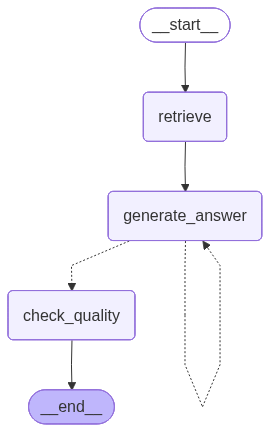

In [13]:
from IPython.display import Image


def build_traditional_graph():
    """Construct graph using traditional routing pattern"""
    
    # Initialize graph with our state schema
    workflow = StateGraph(DocumentQAState)
    
    # Add nodes
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("generate_answer", generate_answer)
    workflow.add_node("check_quality", check_quality)
    
    # Add edges
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "generate_answer")
    
    # Conditional edge: routing function decides next step
    workflow.add_conditional_edges(
        "generate_answer",
        route_by_quality,  # Function that returns next node name
        {
            "generate_answer": "generate_answer",  # Can loop back to self
            "check_quality": "check_quality"
        }
    )
    
    workflow.add_edge("check_quality", END)
    
    # Compile the graph
    return workflow.compile()

traditional_graph = build_traditional_graph()
print("Traditional graph compiled successfully")

display(Image(traditional_graph.get_graph().draw_mermaid_png()))


## Build the Graph - Modern Command Pattern

Building with Command objects - the current recommended approach.
Nodes handle their own routing, making control flow more explicit.

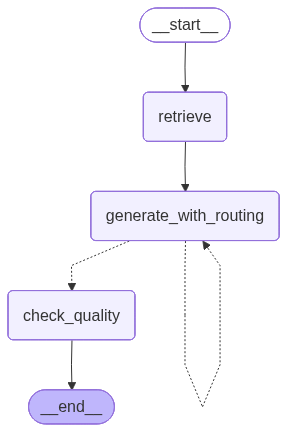

Modern Command-based graph compiled successfully


In [14]:
def build_modern_graph():
    """Construct graph using modern Command pattern"""
    
    # Same state schema
    workflow = StateGraph(DocumentQAState)
    
    # Add nodes - generate_with_routing uses Command
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("generate_with_routing", generate_with_routing)
    workflow.add_node("check_quality", check_quality)
    
    # Simpler edge structure - routing handled in nodes
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "generate_with_routing")
    # No conditional edges needed - Command handles routing
    workflow.add_edge("check_quality", END)
    
    return workflow.compile()

modern_graph = build_modern_graph()
display(Image(modern_graph.get_graph().draw_mermaid_png()))
print("Modern Command-based graph compiled successfully")

## Ways to Invoke Your Graph - Method 1: Standard Invoke

`.invoke()` - Synchronous, blocking execution

Returns the final state after all nodes complete.
Use when you need the complete result before continuing.

In [15]:
def test_invoke():
    """Demonstrate standard invoke method"""
    
    initial_state = {
        "question": "What is the transformer architecture in deep learning?",
        "documents": [],
        "messages": [],
        "answer": "",
        "iteration": 0,
        "confidence_scores": []
    }
    
    # Run the graph to completion
    result = traditional_graph.invoke(initial_state)
    
    print("=== Invoke Result ===")
    print(f"Question: {result['question']}")
    print(f"Answer: {result['answer'][:200]}...")
    print(f"Total iterations: {result['iteration']}")
    print(f"Confidence scores: {result['confidence_scores']}")
    
    return result

invoke_result = test_invoke()

=== Invoke Result ===
Question: What is the transformer architecture in deep learning?
Answer: The transformer is an artificial neural network architecture based on the multi-head attention mechanism, where text is converted to numerical representations called tokens, and each token is contextu...
Total iterations: 1
Confidence scores: [0.85]


## Ways to Invoke Your Graph - Method 2: Stream for Real-time Updates

`.stream()` - Yields intermediate results as nodes complete

Shows progress in real-time, crucial for user experience.
Each yielded value shows state after one node executes.

In [16]:
def test_stream():
    """Demonstrate streaming execution"""
    
    initial_state = {
        "question": "How do transformers use self-attention?",
        "documents": [],
        "messages": [],
        "answer": "",
        "iteration": 0,
        "confidence_scores": []
    }
    
    print("=== Streaming Execution ===")
    
    # Stream returns each node's output as it completes
    for i, step in enumerate(traditional_graph.stream(initial_state)):
        print(f"\nStep {i+1}:")
        # Each step is a dict with node name as key
        for node_name, node_output in step.items():
            print(f"  Node '{node_name}' completed")
            if 'answer' in node_output and node_output['answer']:
                print(f"  Generated answer: {node_output['answer'][:100]}...")

test_stream()

=== Streaming Execution ===

Step 1:
  Node 'retrieve' completed

Step 2:
  Node 'generate_answer' completed
  Generated answer: According to Document 1, transformers use a "parallel multi-head attention mechanism" where "each to...

Step 3:
  Node 'check_quality' completed


## Ways to Invoke Your Graph - Method 3: With Config

Passing configuration for:
- Thread ID for conversation persistence
- Recursion limits
- Custom metadata
- Checkpointing behavior

In [17]:
def test_with_config():
    """Demonstrate invoke with configuration"""
    
    initial_state = {
        "question": "Explain attention mechanisms briefly",
        "documents": [],
        "messages": [],
        "answer": "",
        "iteration": 0,
        "confidence_scores": []
    }
    
    # Configuration object
    config = {
        "recursion_limit": 10,  # Max iterations before stopping
        "metadata": {
            "user_id": "demo_user",
            "session_id": "session_123"
        }
    }
    
    result = traditional_graph.invoke(initial_state, config=config)
    
    print("=== Configured Invoke Result ===")
    print(f"Answer: {result['answer'][:150]}...")
    print(f"Iterations used: {result['iteration']}")
    
    return result

config_result = test_with_config()

=== Configured Invoke Result ===
Answer: The multi-head attention mechanism is a key component of the transformer architecture, allowing each token to be contextualized within the scope of th...
Iterations used: 1


## Common Pitfalls - Pitfall 1: Forgetting List Wrapper

**PITFALL**: Returning single values instead of lists with add_messages reducer

The add_messages reducer expects a LIST of messages.
If you return a single message, it will fail.

In [18]:
# WRONG - Will cause errors
def wrong_node(state: ChatState) -> dict:
    response = llm.invoke("Hello")
    return {
        "messages": response  # ERROR: Should be [response]
    }

# CORRECT - Always return a list
def correct_node(state: ChatState) -> dict:
    response = llm.invoke("Hello")
    return {
        "messages": [response]  # Wrapped in list
    }

print("Pitfall 1: Always wrap messages in lists with add_messages")

Pitfall 1: Always wrap messages in lists with add_messages


## Common Pitfalls - Pitfall 2: State Mutation

**PITFALL**: Mutating state directly instead of returning updates

LangGraph expects nodes to return NEW state, not modify existing state.
Direct mutation breaks the update mechanism.

In [19]:
# WRONG - Mutates state directly
def wrong_mutation(state: DocumentQAState) -> dict:
    state['answer'] = "Modified"  # BAD: Direct mutation
    return state

# CORRECT - Return state updates
def correct_mutation(state: DocumentQAState) -> dict:
    return {
        "answer": "Modified"  # GOOD: Return update dict
    }

print("Pitfall 2: Never mutate state directly, return update dicts")

Pitfall 2: Never mutate state directly, return update dicts


## Common Pitfalls - Pitfall 3: No Reducer on Lists

**PITFALL**: Using lists without reducers leads to overwriting

Without a reducer, returning a list REPLACES the entire list.
This loses previous data, especially bad for messages.

In [20]:
# WRONG - No reducer, overwrites everything
class BadListState(TypedDict):
    items: list  # Will overwrite on each update

# CORRECT - Use add reducer for accumulation
class GoodListState(TypedDict):
    items: Annotated[list, add]  # Appends instead of replacing

print("Pitfall 3: Always use reducers for lists you want to accumulate")

Pitfall 3: Always use reducers for lists you want to accumulate


## Common Pitfalls - Pitfall 4: Type Annotation Mistakes

**PITFALL**: Forgetting return type hints with Command

When using Command, you MUST annotate which nodes you route to.
This is required for graph rendering and validation.

In [21]:
# WRONG - No type hint, LangGraph can't validate
def wrong_command(state: DocumentQAState):
    return Command(update={"answer": "Done"}, goto="next_node")

# CORRECT - Type hint specifies possible destinations
def correct_command(state: DocumentQAState) -> Command[Literal["next_node", "other_node"]]:
    return Command(update={"answer": "Done"}, goto="next_node")

print("Pitfall 4: Always annotate Command return types with possible destinations")

Pitfall 4: Always annotate Command return types with possible destinations


## State Features - Feature 1: Multiple State Keys

State can have multiple keys with different behaviors:
- Some with reducers (accumulate)
- Some without (overwrite)
- Mix and match based on your needs

In [22]:
class MultiFeatureState(TypedDict):
    # Accumulating fields
    messages: Annotated[list, add_messages]  # Append messages
    scores: Annotated[list[float], add]  # Append scores
    
    # Overwriting fields
    current_step: str  # Replace on each update
    iteration: int  # Replace on each update
    
    # Complex nested structures
    metadata: dict  # Replace entire dict

print("Feature 1: Mix accumulating and overwriting fields in same state")

Feature 1: Mix accumulating and overwriting fields in same state


## State Features - Feature 2: Custom Reducers

You can write custom reducer functions beyond add and add_messages.
Reducers take (existing_value, new_value) and return merged value.

In [23]:
def max_reducer(existing: int, new: int) -> int:
    """Custom reducer that keeps the maximum value"""
    return max(existing, new)

def concatenate_with_separator(existing: str, new: str) -> str:
    """Custom reducer for string concatenation"""
    return f"{existing} | {new}" if existing else new

# Use custom reducers in state
class CustomReducerState(TypedDict):
    max_score: Annotated[int, max_reducer]
    log: Annotated[str, concatenate_with_separator]

print("Feature 2: Create custom reducers for specialized merging logic")

Feature 2: Create custom reducers for specialized merging logic


## State Features - Feature 3: Input/Output Schema Control

You can specify different schemas for:
- Graph input (what users provide)
- Internal state (what nodes use)
- Graph output (what gets returned)


In [24]:
class InputSchema(TypedDict):
    question: str  # User only provides question

class OutputSchema(TypedDict):
    answer: str  # User only sees answer

class InternalState(TypedDict):
    question: str
    answer: str
    documents: list[str]  # Internal only
    iteration: int  # Internal only

# Build graph with separate schemas
def build_with_schemas():
    workflow = StateGraph(
        InternalState,
        input_schema=InputSchema,
        output_schema=OutputSchema
    )
    # ... add nodes and edges
    return workflow

print("Feature 3: Control input/output schemas separately from internal state")

Feature 3: Control input/output schemas separately from internal state


## Best Practices Summary

**KEY TAKEAWAYS FOR PRODUCTION LANGGRAPH**:

**1. STATE DESIGN**
   - Use TypedDict for all state definitions
   - Apply reducers (add, add_messages) to lists that accumulate
   - Keep state flat and simple when possible

**2. NODE DESIGN**
   - One clear responsibility per node
   - Return update dicts, never mutate state directly
   - Use Command for nodes that need routing logic

**3. ROUTING**
   - Prefer Command over add_conditional_edges (modern pattern)
   - Annotate Command return types with Literal[possible_nodes]
   - Keep routing logic in nodes where the decision is made

**4. ERROR HANDLING**
   - Use RetryPolicy for transient failures
   - Let unexpected errors bubble up for debugging
   - Store errors in state for LLM-recoverable issues

**5. MESSAGES**
   - Always wrap messages in lists with add_messages
   - Use proper message types (HumanMessage, AIMessage, SystemMessage)
   - add_messages handles deduplication and updates automatically

**6. TESTING**
   - Test with .invoke() first (simplest)
   - Use .stream() for production (better UX)
   - Add config for thread_id when using checkpointers

## Complete Working Example

Putting it all together: A complete document Q&A agent
demonstrating all the concepts we've covered.

In [25]:
class CompleteAgentState(TypedDict):
    messages: Annotated[list, add_messages]
    documents: list[str]
    question: str
    answer: str
    iteration: int

In [26]:
def retrieve_node(state: CompleteAgentState) -> dict:
    """Load Wikipedia documents about the question topic"""
    docs = load_wikipedia_content()
    return {
        "documents": docs,
        "iteration": 0
    }

def answer_node(state: CompleteAgentState) -> Command[Literal["quality_check", END]]:
    """Generate answer and route based on quality"""
    question = state['question']
    docs = state['documents']
    iteration = state['iteration']
    
    context = "\n\n".join(docs)
    prompt = f"Context:\n{context}\n\nQuestion: {question}\n\nProvide a clear, concise answer:"
    
    response = llm.invoke([HumanMessage(content=prompt)])
    answer = response.content
    
    # Route based on answer quality and iteration
    if len(answer) > 100 or iteration >= 2:
        next_node = END
    else:
        next_node = "quality_check"
    
    return Command(
        update={
            "answer": answer,
            "iteration": iteration + 1,
            "messages": [
                HumanMessage(content=question),
                AIMessage(content=answer)
            ]
        },
        goto=next_node
    )

def quality_check_node(state: CompleteAgentState) -> Command[Literal["answer_node", END]]:
    """Check if answer needs improvement"""
    answer = state['answer']
    iteration = state['iteration']
    
    if iteration >= 3:
        return Command(update={}, goto=END)
    
    # Simple quality check
    quality_ok = len(answer) > 100 and len(answer) < 1000
    
    next_node = END if quality_ok else "answer_node"
    
    return Command(
        update={
            "messages": [SystemMessage(content=f"Quality check: {'Passed' if quality_ok else 'Needs improvement'}")]
        },
        goto=next_node
    )

In [27]:
# Build complete graph
def build_complete_graph():
    workflow = StateGraph(CompleteAgentState)
    
    workflow.add_node("retrieve", retrieve_node)
    workflow.add_node("answer_node", answer_node)
    workflow.add_node("quality_check", quality_check_node)
    
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "answer_node")
    
    return workflow.compile()

complete_graph = build_complete_graph()
print("Complete agent graph built successfully")

Complete agent graph built successfully


In [28]:
# Test the complete agent
test_question = "What are the key components of transformer architecture?"

final_result = complete_graph.invoke({
    "question": test_question,
    "documents": [],
    "messages": [],
    "answer": "",
    "iteration": 0
})

print("=== Complete Agent Result ===")
print(f"Q: {final_result['question']}")
print(f"A: {final_result['answer'][:300]}...")
print(f"Total iterations: {final_result['iteration']}")
print(f"Messages in history: {len(final_result['messages'])}")

=== Complete Agent Result ===
Q: What are the key components of transformer architecture?
A: The key components of the transformer architecture are:

1. Multi-head attention mechanism
2. Word embedding table (for converting tokens to vectors)

These components enable the transformer to contextualize tokens within a context window, allowing it to amplify important signals and diminish less i...
Total iterations: 1
Messages in history: 2


## Visualizing Your Graph (Optional)

LangGraph provides built-in visualization.
Requires additional dependencies: `pip install grandalf`

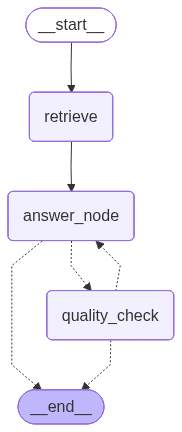

Graph visualization generated


In [29]:
try:
    from IPython.display import Image, display
    
    # Generate graph visualization
    graph_image = complete_graph.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("Graph visualization generated")
except ImportError:
    print("Install IPython and grandalf for graph visualization")
except Exception as e:
    print(f"Visualization not available: {e}")

**NEXT TOPICS TO EXPLORE**:
1. Checkpointers - Save state between runs (human-in-the-loop)
2. Streaming - Real-time progress updates
3. Subgraphs - Compose graphs for complex workflows
4. RetryPolicy - Automatic error recovery
5. Tools integration - Search, databases, APIs
